In [6]:
from artem import *

In [7]:
ss = pdb.parser('data/1xjr.cif', 'CIF', 'ss')

In [15]:
a = [None]* 10
a[0] = 10
a

[10, None, None, None, None, None, None, None, None, None]

In [19]:
class Dog:
    def walk(self):
        return "*walking*"

    def speak(self):
        return "Woof!"

class JackRussellTerrier(Dog):
    def talk(self):
        return super().speak()

bobo = JackRussellTerrier()
bobo.talk()

'Woof!'

In [23]:
df = pd.DataFrame()
df.empty

True

In [11]:
ss.get_code_mask()

0         1.A.GTP.1.
1         1.A.GTP.1.
2         1.A.GTP.1.
3         1.A.GTP.1.
4         1.A.GTP.1.
            ...     
1032    1.A.HOH.208.
1033    1.A.HOH.209.
1034    1.A.HOH.210.
1035    1.A.HOH.211.
1036    1.A.HOH.212.
Length: 1037, dtype: object

In [8]:
import matplotlib.pyplot as plt

In [85]:
with open('memo.txt', 'r') as file:
    text = file.read()

rows = []
for r in text.split('\n')[:-1]:
    rows.append(list(map(float, r.split())))
rows.sort(key=lambda x: x[0])
cnt, proc, memo, time = zip(*rows)

In [86]:
(time[-1] - time[0]) / 60

4.176164038976034

In [87]:
proc[-1]

0.033

In [4]:
REMARK_FORMAT = 'REMARK 250 CHAIN RENAMING {} -> {}'

In [5]:
s = REMARK_FORMAT.format('sdf', 'a')
len(s), s

(113,
 'REMARK 250 CHAIN RENAMING sdf -> a                                                                               ')

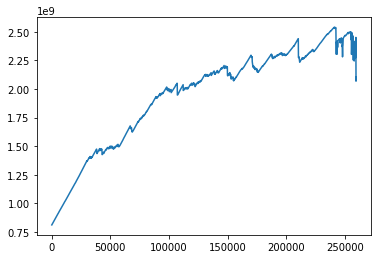

In [89]:
plt.plot(cnt, memo)

In [4]:
import psutil
psutil.Process().memory_info().rss / (1024 * 1024)

63.640625

In [3]:
psutil.Process().memory_info()

pmem(rss=66732032, vms=419108700160, pfaults=9677, pageins=176)

In [1]:
import time

In [2]:
time.time()

1666482540.7723

In [5]:
(1109721088 - 684490752)

425230336

In [2]:
def task(m, n):
    transform  = get_transform(r_prim[m], q_prim[n])
    
    q_avg_tree = KDTree(apply_transform(q_avg, transform))
    dist = r_avg_tree.sparse_distance_matrix(
        q_avg_tree,
        matchrange,
        p=2,
        output_type='ndarray'
    )
    
    nb   = mutual_nb(dist)
    size = len(nb)
    if not sizemin <= size <= sizemax:
        return None
    
    scnd = vstack([[r_scnd[i], q_scnd[j]] for i, j in nb])
    transform  = get_transform(*scnd)
    
    r_coord, q_coord = vstack([[r_eval[i], q_eval[j]] for i, j in nb])
    q_coord = apply_transform(q_coord, transform)
    
    rmsd = RMSD(r_coord, q_coord)
    if not rmsdmin <= rmsd <= rmsdmax:
        return None
    
    rmsdsize = rmsd / size
    if not rmsdsizemin <= rmsdsize <= rmsdsizemax:
        return None
    
    if saveto:
        sup_sstract = sstruct.apply_transform(transform)
        sup_sstract.rename('{}_{}_{}'.format(sup_sstract, m, n))
        sup_sstract.saveto('tmp', saveformat)
    
    nb = tuple(sorted(nb))
    return (nb, rmsd)

In [3]:
argv = [
    'r=data/1xjr.cif', 
    'q=data/1xjr.pdb', 
    # 'rmsdmax=3', 
    # 'sizemin=20',
    'saveto=results', 
    'threads=-1',
    # 'qres=/A:A_45'
    # 'rres=/X:A_0_100',
    # 'rresneg=/X:_100_500',
    # 'rseed=/X:A_0_20' 
]

In [4]:
# Processing inputs
# argv = sys.argv[1:]

if argv[0] in {'--H', '-H', '--h', '-h', '--help', '-help'}:
    with open('help.txt', 'r') as help:
        print(*help)
    exit(0)
else:
    kwargs = dict([arg.split('=') for arg in argv])

threads = int(kwargs.get('threads', threads))
if threads != 1:
    # Multiprocessing is available only for UNIX-like systems
    mp.set_start_method('fork')
    
    if threads < 0:
        threads = mp.cpu_count()
    else:
        threads = min(threads, mp.cpu_count())

r       = kwargs.get('r')
rres    = kwargs.get('rres', rres)
rresneg = kwargs.get('rresneg', rresneg)
rseed   = kwargs.get('rseed', rseed)
rformat = kwargs.get('rformat', rformat)

q       = kwargs.get('q')
qres    = kwargs.get('qres', qres)
qresneg = kwargs.get('qresneg', qresneg)
qseed   = kwargs.get('qseed', qseed)
qformat = kwargs.get('qformat', qformat)

sizemin     = float(kwargs.get('sizemin', sizemin))
sizemax     = float(kwargs.get('sizemax', sizemax))

rmsdmin     = float(kwargs.get('rmsdmin', rmsdmin))
rmsdmax     = float(kwargs.get('rmsdmax', rmsdmax))

rmsdsizemin = float(kwargs.get('rmsdsizemin', rmsdsizemin))
rmsdsizemax = float(kwargs.get('rmsdsizemax', rmsdsizemax))

matchrange  = float(kwargs.get('matchrange', matchrange))

saveto     = kwargs.get('saveto', saveto)
saveres    = kwargs.get('saveres', saveres)

rname, rext = r.split(os.sep)[-1].split('.')
qname, qext = q.split(os.sep)[-1].split('.')

available_format = {'PDB', 'CIF'}

rext = rext.upper()
if rext in available_format:
    rformat = rext

qext = qext.upper()
if qext in available_format:
    qformat = qext

saveformat = kwargs.get('saveformat', qformat).upper()

if saveformat not in available_format:
    if saveformat == 'MMCIF':
        saveformat = 'CIF'
    else:
        msg = 'Invalid saveformat value. Acceptable values for saveformat'
        msg+= 'are PDB, CIF or MMCIF (case-insensitive)'
        raise TypeError(msg)

In [5]:
# Model preprocessing

rstruct  = pdb.parser(r, rformat, rname)
rstruct.drop_duplicates_alt_id(keep=keep)
rnegcase = bool(rresneg)
rsstruct = rstruct.get_res_substruct(
    [rres, rresneg][rnegcase],
    rnegcase
)
rrres, rures = rsstruct.artem_desc(seed_res_repr)
if not rrres:
    msg = 'No {}={} nucleotides in the {} for seed'.format(
        ['rres', 'rresneg'][rnegcase],
        [rres, rresneg][rnegcase],
        r
    )
    raise ValueError(msg)
rseed_code = rsstruct.get_res_code(rseed)
if not rseed_code:
    msg = 'No rseed={} nucleotides in the {}={} for seed {}'.format(
        rseed,
        ['rres', 'rresneg'][rnegcase],
        [rres, rresneg][rnegcase],
        r
    )
    raise ValueError(msg)


r_code, r_prim, r_avg, r_scnd, r_eval = zip(*rrres)
r_avg = np.vstack(r_avg)
rseed_code = set(r_code) & set(rseed_code)
r_ind = [i for i, code in enumerate(r_code) if code in rseed_code]

In [6]:
qstruct  = pdb.parser(q, qformat, qname)
qstruct.drop_duplicates_alt_id(keep=keep)
qnegcase = bool(qresneg)
qsstruct = qstruct.get_res_substruct(
    [qres, qresneg][qnegcase],
    qnegcase
)
qrres, qures = qsstruct.artem_desc(seed_res_repr)
if not qrres:
    msg = 'No {}={} nucleotides in the {} for seed'.format(
        ['qres', 'qresneg'][qnegcase],
        [qres, qresneg][qnegcase],
        q
    )
    raise ValueError(msg)
qseed_code = qsstruct.get_res_code(qseed)
if not qseed_code:
    msg = 'No qseed={} nucleotides in the {}={} for seed {}'.format(
        qseed,
        ['qres', 'qresneg'][qnegcase],
        [qres, qresneg][qnegcase],
        q
    )
    raise ValueError(msg)

q_code, q_prim, q_avg, q_scnd, q_eval = zip(*qrres)
q_count = len(q_code)
q_avg = np.vstack(q_avg)
qseed_code = set(q_code) & set(qseed_code)
q_ind = [i for i, code in enumerate(q_code) if code in qseed_code]

In [7]:
# Preparing a saved structure
if saveto:
    if saveres:
        sstruct = qstruct.get_res_substruct(saveres)
    else:
        sstruct = qsstruct
    tmp_fmt  = 'tmp/' + sstruct.name + '_{}_{}.' + saveformat.lower()
    save_fmt = saveto + '/' + sstruct.name + '_{}.' + saveformat.lower()

In [8]:
# ARTEM Computations 

indx_pairs = list(itertools.product(r_ind, q_ind))

r_avg_tree = KDTree(r_avg)
if threads == 1:
    result = [task(m, n) for m, n in indx_pairs]
else:
    pool = mp.Pool(threads)
    
    delta   = 15 * threads
    cnt     = 0
    cnt_max = len(indx_pairs)
    result  = []
    while cnt < cnt_max:
        result.extend(
            pool.starmap(task, indx_pairs[cnt:cnt + delta])
        )
        cnt += delta

In [9]:
rows = {}
for i, rslt in enumerate(result):
    if rslt:
        nb, rmsd = rslt
    else:
        continue
    
    if nb in rows:
        row = rows[nb]
        if rmsd < row[0]:
            row[0] = rmsd
            row.insert(1, i)
        else:
            row.append(i)
    else:
        rows[nb] = [rmsd, i]
rows = [[i, *v] for i, v in rows.items()]

In [11]:
tabrows = []
rm = []
for i, row in enumerate(rows):
    nb   = row[0]
    rmsd = row[1]
    size = len(nb)
    rmsdsize = rmsd / size
    file_id = row[2]
    
    seed_id = row[2:]
    
    prim = ','.join(
        [
            '='.join([r_code[s // q_count], q_code[s % q_count]])
            for s in seed_id
        ]
    )
    scnd = ','.join(
        [
            '='.join([r_code[m], q_code[n]])
            for m, n in nb
        ]
    )
    
    tabrows.append((file_id, size, rmsd, rmsdsize, prim, scnd))

In [19]:
columns = ['ID', 'SIZE', 'RMSD', 'RMSDSIZE', 'PRIM', 'SCND']
tab = pd.DataFrame(tabrows, columns=columns)
tab.sort_values(
    ['SIZE', 'RMSDSIZE'], 
    ascending=[True, False], 
    inplace=True
)
tab.index = list(range(1, len(tab) + 1))
rnm = dict(zip(tab['ID'], tab.index))

In [20]:
tab

,ID,SIZE,RMSD,RMSDSIZE,PRIM,SCND
1,1265,1,9.074518e-01,9.074518e-01,1.A.A.29.=1.A.U.25.,1.A.A.29.=1.A.U.25.
2,1085,1,9.074518e-01,9.074518e-01,1.A.U.25.=1.A.A.29.,1.A.U.25.=1.A.A.29.
3,1082,1,9.072815e-01,9.072815e-01,1.A.U.25.=1.A.A.26.,1.A.U.25.=1.A.A.26.
4,1127,1,9.072815e-01,9.072815e-01,1.A.A.26.=1.A.U.25.,1.A.A.26.=1.A.U.25.
5,1771,1,9.070997e-01,9.070997e-01,1.A.A.40.=1.A.U.25.,1.A.A.40.=1.A.U.25.
...,...,...,...,...,...,...
1955,93,24,2.236159e+00,9.317327e-02,1.A.G.4.=1.A.A.3.,"1.A.A.3.=1.A.G.2.,1.A.G.4.=1.A.A.3.,1.A.U.5.=1..."
1956,48,24,2.236159e+00,9.317327e-02,1.A.A.3.=1.A.G.4.,"1.A.G.2.=1.A.A.3.,1.A.A.3.=1.A.G.4.,1.A.G.4.=1..."
1957,2114,26,2.346592e+00,9.025353e-02,1.A.U.47.=1.A.U.46.,"1.A.G.2.=1.A.A.3.,1.A.A.3.=1.A.G.4.,1.A.G.4.=1..."
1958,2069,26,2.346592e+00,9.025353e-02,1.A.U.46.=1.A.U.47.,"1.A.A.3.=1.A.G.2.,1.A.G.4.=1.A.A.3.,1.A.U.5.=1..."


In [15]:
os.makedirs(saveto, exist_ok=True)

In [16]:
for k, v in list(rnm.items())[1:]:
    os.rename(tmp_fmt.format(*indx_pairs[k]), save_fmt.format(v))

In [32]:
os.rmdir('tmp')

OSError: [Errno 66] Directory not empty: 'tmp'

In [ ]:
sorted([int(s.split('_')[0]) for s in os.listdir(saveto)])

[28,
 45,
 47,
 49,
 61,
 71,
 74,
 87,
 88,
 89,
 90,
 94,
 109,
 115,
 120,
 133,
 139,
 141,
 144,
 145,
 146,
 148,
 154,
 177,
 179,
 183,
 188,
 207,
 212,
 227,
 235,
 237,
 240,
 244,
 253,
 258,
 261,
 270,
 272,
 273,
 275,
 279,
 282,
 299,
 304,
 307,
 318,
 319,
 325,
 329,
 331,
 332,
 345,
 350,
 362,
 365,
 367,
 368,
 371,
 376,
 378,
 389,
 391,
 396,
 412,
 418,
 419,
 420,
 421,
 422,
 423,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 437,
 438,
 439,
 440,
 441,
 449,
 453,
 455,
 456,
 457,
 458,
 459,
 460,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 470,
 476,
 477,
 478,
 479,
 483,
 485,
 486,
 487,
 489,
 492,
 494,
 496,
 497,
 500,
 501,
 502,
 503,
 504,
 505,
 517,
 524,
 526,
 529,
 533,
 534,
 537,
 550,
 564,
 570,
 572,
 575,
 579,
 580,
 611,
 616,
 619,
 621,
 622,
 626,
 653,
 658,
 664,
 665,
 667,
 668,
 670,
 672,
 675,
 696,
 699,
 700,
 705,
 710,
 711,
 713,
 717,
 718,
 736,
 738,
 739,
 745,
 746,
 752,
 754,
 756,
 757,
 758,
 759,
 760